In [41]:
import pandas as pd

import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
import matplotlib.cm as cm
from shapely import Point

import seaborn as sns
import numpy as np
from adjustText import adjust_text

from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud


# 1 National Participation Plot

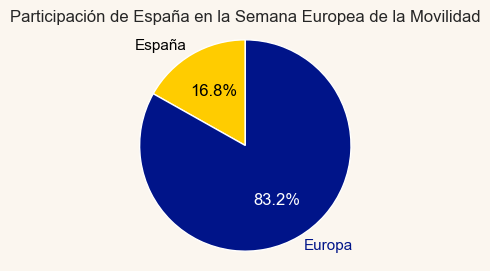

In [64]:

spain_cities = 466
total_cities = 2766

# Data for the pie chart
sizes = [spain_cities, total_cities - spain_cities]
labels = ['España', 'Europa']
colors = ['#FFCC00', '#001489']  # Yellow for Spain, gray for others

# Create the pie chart
fig, ax = plt.subplots(figsize=(3, 3))  # Create a figure and axes
wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)

# Set the background colors
fig.patch.set_facecolor('#fbf6ef')  # Background of the figure
ax.set_facecolor('#fbf6ef')  # Background of the axes

# Set colors for the text
texts[0].set_color('black')  # Color for España
texts[1].set_color('#001489')  # Color for Europa

# Set colors for the percentage texts
autotexts[0].set_color('black')  # Percentage for España
autotexts[1].set_color('white')  # Percentage for Europa

# Final adjustments
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title(f'Participación de España en la Semana Europea de la Movilidad')
plt.show()


# 2 Mapping

## 2.1 Data Enriching

In [ ]:
df=pd.read_csv('../data/activities_tc.csv')
df_unique_cities = pd.read_csv('../data/activities.csv').drop(['activity_name', 'activity_description', 'ID','Unnamed: 0'], axis=1)
df_unique_cities = df_unique_cities.drop_duplicates()
merged_df = pd.merge(df, df_unique_cities, on='city', how='inner')
display(merged_df)
merged_df.to_csv('../data/activities_tce.csv')

## 2.2 Data Cleaning

In [180]:
merged_df = pd.read_csv('../data/activities_tce.csv')

merged_df['latitude'] = pd.to_numeric(merged_df['latitude'], errors='coerce')
top_northern_activities = merged_df.nlargest(10, 'latitude')
print("Top 10 Northern Activities:")
display(top_northern_activities[['city', 'activity_name', 'latitude','longitude']])

Top 10 Northern Activities:


,city,activity_name,latitude,longitude
927,"Torre-Serona, Spain",Caminada pels carres i camins del municipi,50.838926,4.384220
928,"Torrebesses, Spain",Ruta cicloturística guiada,50.838926,4.384220
929,"Torrebesses, Spain",Caminada verda,50.838926,4.384220
175,"Burela, Spain",Andando al colegio,43.660295,-7.361109
176,"Burela, Spain",Paseo saludable,43.660295,-7.361109
177,"Burela, Spain",Charlas con Stop Accidentes,43.660295,-7.361109
178,"Burela, Spain",Ruta en bici y circuito de habilidad,43.660295,-7.361109
391,"Gijón, Spain",Paseos en bicicletas adaptdas para personas con movilidad reducida,43.532201,-5.661119
392,"Gijón, Spain",Talleres de revisión de bicicletas (ITBicis),43.532201,-5.661119
393,"Gijón, Spain",Biciescuela Adulta. Nivel 1: Cursos para aprender a montar en bicicleta,43.532201,-5.661119


## 2.3 Visualization

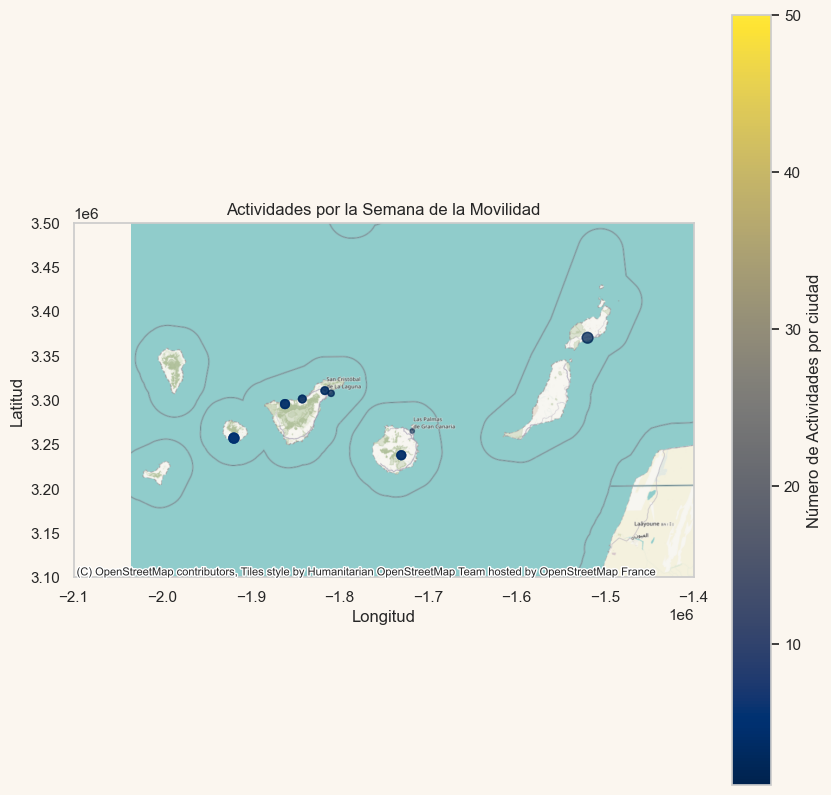

In [19]:


merged_df=pd.read_csv('../data/activities_tce.csv')
# Step 1: Create a GeoDataFrame from merged_df, with geometry from latitude/longitude
merged_df['geometry'] = merged_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
ids_to_drop = [927, 928, 929]
merged_df = merged_df[~merged_df['ID'].isin(ids_to_drop)]
gdf = gpd.GeoDataFrame(merged_df, geometry='geometry')

# Step 2: Group by city and count activities
activity_count = gdf.groupby('city').size().reset_index(name='count')

# Step 3: Merge the activity counts with the original GeoDataFrame
gdf_counts = gdf.merge(activity_count, on='city')

# Step 4: Set the CRS and plot the bubble map
gdf_counts = gdf_counts.set_crs(epsg=4326)  # Set CRS to WGS84 (lat/lon)
gdf_counts = gdf_counts.to_crs(epsg=3857)   # Convert to Web Mercator for plotting

# Normalize the counts for colormap
norm = plt.Normalize(gdf_counts['count'].min(), gdf_counts['count'].max())
colors = cm.cividis(norm(gdf_counts['count']))  # Choose any colormap

# Plot the bubble map
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the cities with bubbles sized according to activity count
gdf_counts.plot(ax=ax, marker='o', color=colors, markersize=gdf_counts['count'] * 10, alpha=0.5)

# Add the basemap using contextily


provider = ctx.providers.Stadia.StamenWatercolor(api_key="77d36c7f-e444-4059-8428-d6f603315297")

# Update the provider URL to include your API key
provider["url"] = provider["url"] + "?api_key={api_key}"
provider = ctx.providers.OpenStreetMap.HOT
ctx.add_basemap(ax, crs=gdf_counts.crs.to_string(), source=provider, zoom=8)

# Set titles and labels
ax.set_title('Actividades por la Semana de la Movilidad')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

fig.patch.set_facecolor('#fbf6ef')  # Background of the figure
ax.set_facecolor('#fbf6ef') 

ax.set_xlim([-2.1e6, -1.4e6])
ax.set_ylim([3.1e6, 3.5e6])
# Optional: Add a color bar for activity count
sm = plt.cm.ScalarMappable(cmap=cm.cividis, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Número de Actividades por ciudad')

plt.grid()

# Show the plot
plt.show()

# 3 Top Cities

C:\Users\afontecha\AppData\Local\Temp\ipykernel_15448\2423030138.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_counts.index, y=city_counts.values, palette="cividis_r", ax=ax)


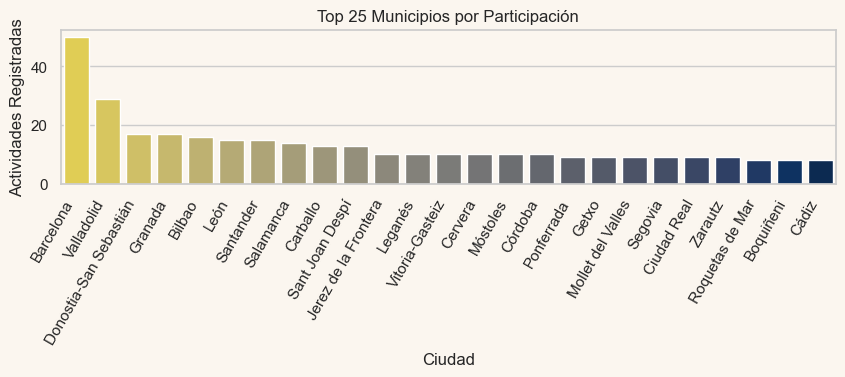

In [65]:
def plot_top_cities(df, top_n=20):
    city_counts = df['city'].value_counts().nlargest(top_n)
    
    # Create the figure and axes objects
    fig, ax = plt.subplots(figsize=(10, 2))
    
    # Create the bar plot
    sns.barplot(x=city_counts.index, y=city_counts.values, palette="cividis_r", ax=ax)
    
    # Set the background color for the figure and axes
    fig.patch.set_facecolor('#fbf6ef')  # Background of the figure
    ax.set_facecolor('#fbf6ef')  # Background of the axes
    
    # Customize the plot
    plt.title(f"Top {top_n} Municipios por Participación")
    plt.xlabel("Ciudad")
    plt.ylabel("Actividades Registradas")
    plt.xticks(rotation=60, ha='right')
    
    # Show the plot
    plt.show()

df = pd.read_csv('../data/activities_tce.csv')
df['city'] = df['city'].apply(lambda x: x.split('(')[0].split(',')[0].strip())
plot_top_cities(df,25)

# 4 Scatter Plot

In [ ]:

def scatter_plot(df):
    df=df[df['city'] != 'Villena']
    city_activity_counts = df.groupby('city').agg(
        activity_count=('classification_to_plot', 'size'),  # Count activities
        max_population=('population', 'max')  # Get maximum population
    ).reset_index()

    # Step 2: Plotting
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Create the scatter plot
    ax.scatter(city_activity_counts['max_population'], city_activity_counts['activity_count'], color='#3a6c7f', alpha=0.6)
    

    plt.title('Municipios según su participación y habitantes')
    plt.xlabel('Habitantes')
    plt.ylabel('Actividades Registradas')
    
    fig.patch.set_facecolor('#fbf6ef')  # Background of the figure
    ax.set_facecolor('#fbf6ef')  # Background of the axes
    ax.xaxis.get_major_formatter().set_scientific(False)
    texts=[]
    radius=60000
    coords = city_activity_counts[['max_population', 'activity_count']].values
    
    for i in range(len(city_activity_counts)):
        # Get the same activity count for the current city
        current_activity_count = city_activity_counts['activity_count'].iloc[i]
        
        # Filter cities with the same activity count
        same_count_indices = city_activity_counts[city_activity_counts['activity_count'] == current_activity_count].index
        
        # Check if the x-distance from the current point to other points with the same activity count is greater than the threshold
        if all(abs(coords[i][0] - coords[j][0]) > radius for j in same_count_indices if j != i):
        
            texts.append(ax.annotate(city_activity_counts['city'].iloc[i], 
                                  (city_activity_counts['max_population'].iloc[i], city_activity_counts['activity_count'].iloc[i]),
                                  ha='center',
                                  fontweight='bold'))

    # Use adjustText to prevent overlap of labels
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))
    plt.grid()
    plt.show()
    
df['classification_to_plot'] = df.apply(
    lambda row: (
        'Other' if row['primary_score'] <= THRESHOLD else
        row['primary_classification'] #if pd.isna(row['secondary_classification']) else
        #f"{row['primary_classification']} - Other" if row['secondary_score'] <= THRESHOLD else
        #f"{row['primary_classification']} - {row['secondary_classification']}"
    ),
    axis=1
)
scatter_plot(df)

# 5 Word Count

In [ ]:
nltk.download('stopwords')

In [136]:
english_stop_words = stopwords.words('english')
catalan_stop_words = stopwords.words('catalan')
spanish_stop_words = stopwords.words('spanish')
custom_filter=['available','description']
# Load the DataFrame (replace with your actual file)
df = pd.read_csv('../data/activities_tc.csv')

# Fill any NaN values with empty strings to avoid errors
df['activity_name'] = df['activity_name'].fillna('')
df['activity_description'] = df['activity_description'].fillna('')

# Combine the 'name' and 'description' into a single text column
df['combined_text'] = df['activity_name'] + ' ' + df['activity_description']

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=spanish_stop_words+catalan_stop_words+english_stop_words+custom_filter, max_features=20)  # limit to 20 most relevant terms

# Fit the vectorizer to the combined text column
tfidf_matrix = tfidf_vectorizer.fit_transform(df['combined_text'])

# Get the feature names (i.e., terms)
terms = tfidf_vectorizer.get_feature_names_out()

# Sum the TF-IDF scores across all documents (rows) to get overall term importance
sum_tfidf_scores = tfidf_matrix.sum(axis=0)

# Create a DataFrame of terms and their corresponding TF-IDF scores
tfidf_scores_df = pd.DataFrame({'term': terms, 'score': sum_tfidf_scores.tolist()[0]})

# Sort the terms by their score in descending order to see the most important terms
tfidf_scores_df = tfidf_scores_df.sort_values(by='score', ascending=False)

# Display the most relevant terms
print(tfidf_scores_df)


          term       score
3    bicicleta  106.881001
10   movilidad   90.122907
15  sostenible   75.278841
9    mobilitat   70.768082
5     caminada   62.465657
0           00   62.324013
2         bici   60.070546
16      taller   50.425377
8       escola   47.109251
13     popular   45.804184
1           30   42.371328
14        ruta   41.941511
4   bicicletas   37.889043
6       ciudad   37.607664
19        vial   36.827396
7          día   35.774073
12    pedalada   35.014579
17  transporte   34.175262
11      parque   30.963447
18         uso   28.454574


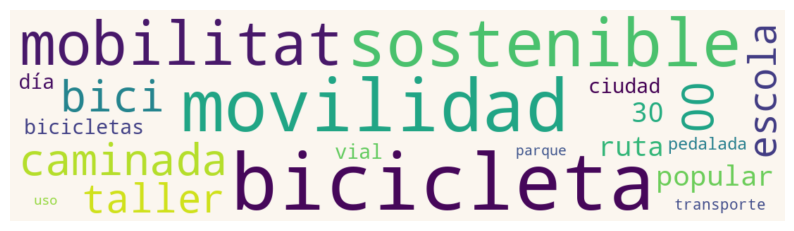

In [154]:
sum_tfidf_scores = tfidf_matrix.sum(axis=0).A1  # Use .A1 to convert to a 1D array

# Create a dictionary of terms and their scores
term_score_dict = dict(zip(terms, sum_tfidf_scores))

# Generate a word cloud
wordcloud = WordCloud(width=1100, height=300, background_color='#fbf6ef',margin=20,    contour_color='black',  contour_width=1,   scale=1  , colormap='viridis'       ).generate_from_frequencies(term_score_dict)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove the axis
plt.show()


# 6 Activity Analysis

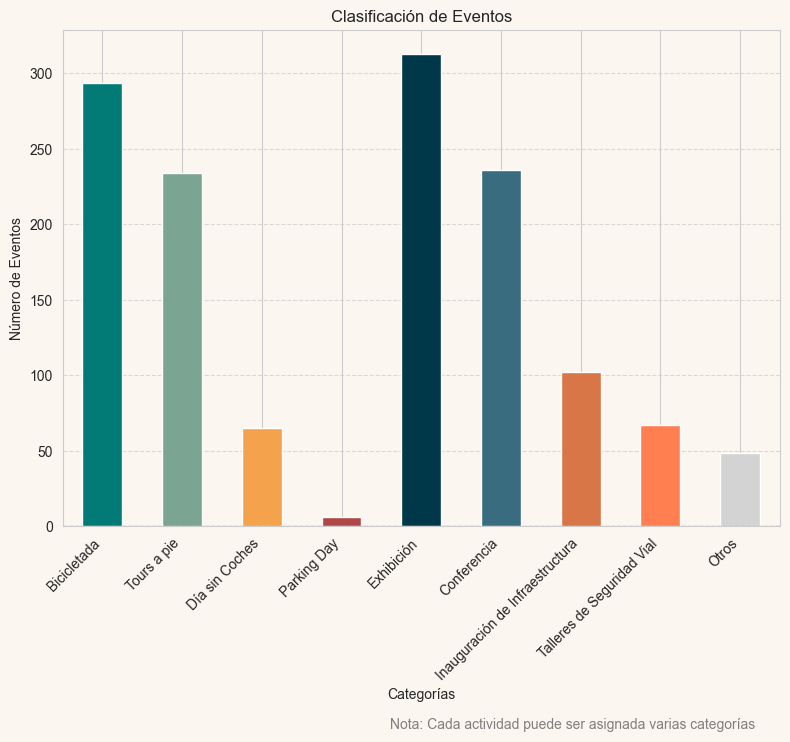

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Read the classification results and validation results
classification_df = pd.read_csv('../data/classification_results.csv').drop(['Unnamed: 0'], axis=1)
validation_df = pd.read_csv('../data/validation_results.csv').drop(['Unnamed: 0'], axis=1)

# Step 2: Set the thresholds in a dictionary
thresholds = {
    'Cycling Event': 0.1,
    'Walking Tour': 0.1,
    'Road Safety Workshop': 0.15,
    'Car-Free Day': 0.25,
    'Parking Day': 0.5,
    'Exhibition': 0.35,
    'Infrastructure Inauguration': 0.15,
    'Conference': 0.35
}

# Step 3: Apply thresholds to get predicted labels
predicted_labels = classification_df[['ID']].copy()  # Start with IDs

# Generate predicted labels based on thresholds
for category, threshold in thresholds.items():
    predicted_labels[category] = (classification_df[category] >= threshold).astype(int)

# Step 5: Count occurrences of each category in predicted_labels
category_counts = predicted_labels.drop(columns=['ID']).sum()

# Step 6: Calculate the number of unclassified instances (Others)
unclassified_rows = (predicted_labels.drop(columns=['ID']).sum(axis=1) == 0).sum()

# Step 6: Add unclassified count to category counts
category_counts['Others'] = unclassified_rows

# Step 7: Define a custom color palette
colors = ['#027A76', '#7BA492', '#F4A24C', '#AF4749', '#003849', '#3A6C7F', '#D87648', '#FF7F50', 'lightgray']  # For all categories + 'Others'
desired_order = ['Cycling Event', 'Walking Tour', 'Car-Free Day', 'Parking Day', 'Exhibition', 'Conference', 'Infrastructure Inauguration', 'Road Safety Workshop', 'Others']
category_counts = category_counts[desired_order]
# Step 8: Create the plot with background color
fig, ax = plt.subplots(figsize=(8, 8))

# Set the background color for the figure and axes
fig.patch.set_facecolor('#fbf6ef')  # Background of the figure
ax.set_facecolor('#fbf6ef')  # Background of the axes

# Plot the final counts including "Others" with the custom color palette
category_counts.plot(kind='bar', color=colors, ax=ax)

# Customize the plot
plt.title('Clasificación de Eventos')
plt.text(0.965, -0.4, 'Nota: Cada actividad puede ser asignada varias categorías', ha='right', va='center', transform=ax.transAxes, fontsize=10, color='gray')

plt.xlabel('Categorías')
plt.ylabel('Número de Eventos')
plt.xticks(rotation=45)
ax.set_xticklabels(['Bicicletada', 'Tours a pie', 'Día sin Coches', 
                    'Parking Day',
                    'Exhibición', 'Conferencia','Inauguración de Infraestructura', 'Talleres de Seguridad Vial', 'Otros'],
                   rotation=45, ha='right')

plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add a baseline
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Show the plot
plt.show()


In [1]:

sns.set(style="whitegrid")
THRESHOLD = 0.30

# Create classification data
df['classification_to_plot'] = df.apply(
    lambda row: (
        'Other' if row['primary_score'] <= THRESHOLD else
        row['primary_classification'] #if pd.isna(row['secondary_classification']) else
        #f"{row['primary_classification']} - Other" if row['secondary_score'] <= THRESHOLD else
        #f"{row['primary_classification']} - {row['secondary_classification']}"
    ),
    axis=1
)

df['city'] = df['city'].apply(lambda x: x.split('(')[0].split(',')[0].strip())

def create_donut_chart(sizes, labels, title, ax):
    wedges, texts = ax.pie(
        sizes,
        labels=labels,
        startangle=90,
        counterclock=False,
        wedgeprops=dict(width=0.3)
    ) if len(labels) > 1 else ax.pie(sizes, labels=labels, startangle=90, counterclock=False)

    ax.set(aspect="equal")
    ax.set_title(title)

    # Draw circle for donut effect
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    # Adjust position and orientation of labels
    for i, text in enumerate(texts):
        angle = (wedges[i].theta1 + wedges[i].theta2) / 2  # Calculate the angle of the wedge
        radius = 1.2  # Adjust this for distance from the center
        # Set the position of the label based on the angle
        x = radius * np.cos(np.radians(angle))
        y = radius * np.sin(np.radians(angle))
        text.set_position((x, y))  # Set new position



def create_bar_chart(sizes, labels, title, ax):
    bars = ax.bar(labels, sizes, color='skyblue', edgecolor='black')
    ax.set(title=title, xlabel='Activities', ylabel='Counts')
    ax.set_xticklabels(labels, rotation=45, ha='right')

    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), int(bar.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black')



def plot_classifications(df):
    counts = df['classification_to_plot'].value_counts()
    fig, ax = plt.subplots(figsize=(8, 8))
    create_bar_chart(counts.values, counts.index, 'Classification of Activities', ax)
    plt.show()


def plot_subcategories(df):
    categories = ['Road Safety Workshop', 'Cultural/Sporting Event', 'Conference']
    titles = ['Road Safety Workshop Subcategories', 'Cultural/Sporting Event Subcategories', 'Conference Subcategories']
    fig, axes = plt.subplots(1, len(categories), figsize=(18, 6))  # Create subplots

    for ax, category, title in zip(axes, categories, titles):
        filtered_df = df[df['classification_to_plot'].str.startswith(category)]
        counts = filtered_df['classification_to_plot'].value_counts()
        create_donut_chart(counts.values, counts.index, title, ax)
    
    plt.tight_layout()  # Adjust layout
    plt.show()

# Example usage
plot_classifications(df)
plot_subcategories(df)



NameError: name 'sns' is not defined

In [36]:
df=pd.read_csv('../data/activities_tc.csv')
THRESHOLD=0.5
df['classification_to_plot'] = df.apply(
    lambda row: (
        'Other' if row['primary_score'] <= THRESHOLD else
        row['primary_classification'] if pd.isna(row['secondary_classification']) else
        f"{row['primary_classification']} - Other" if row['secondary_score'] <= THRESHOLD else
        f"{row['primary_classification']} - {row['secondary_classification']}"
    ),
    axis=1
)
df[df['classification_to_plot'].str.startswith('Conference - Pr')]

,ID,city,activity_name,activity_description,primary_classification,primary_score,secondary_classification,secondary_score,classification_to_plot
4,4,"A Coruña, Spain",La policía local con la movilidad,Una muestra de las diversas actividades que re...,Conference,0.762723,Professionals/Policymakers,0.535225,Conference - Professionals/Policymakers
287,287,"Córdoba, Spain",Jornadas profesionales Arquitectos y Urbanista...,Descripción:\r\nCharla sobre diseño urbano sos...,Conference,0.631896,Professionals/Policymakers,0.510138,Conference - Professionals/Policymakers
288,288,"Córdoba, Spain",Jornadas Legalidad y Nuevos Seguros para Vehíc...,Descripción:\r\nCharla sobre legislación y seg...,Conference,0.760423,Professionals/Policymakers,0.608293,Conference - Professionals/Policymakers
290,290,"Córdoba, Spain",Jornada Vicerrectorado de Transferencia: Proye...,Presentación y discusión de proyectos innovado...,Conference,0.564113,Professionals/Policymakers,0.758482,Conference - Professionals/Policymakers
378,378,"Gavà, Spain",Taller de capacidad viaria,Martes 17 tendrá lugar taller de capacidad via...,Conference,0.579285,Professionals/Policymakers,0.516560,Conference - Professionals/Policymakers
712,712,"Reus, Spain",INSTITUT GABRIEL FERRATER Xerrada informativa ...,Xerrada informativa a l’Institut Gabriel Ferra...,Conference,0.532374,Professionals/Policymakers,0.516655,Conference - Professionals/Policymakers
785,785,"San Cristóbal de La Laguna, Spain",Conquistando el Espacio Público,Se realizará una charla dirigida a los Comités...,Conference,0.737208,Professionals/Policymakers,0.898796,Conference - Professionals/Policymakers
846,846,"Santa Cruz de Tenerife, Spain",TECHNICAL CONFERENCE: Technology and Innovatio...,"THURSDAY, September 19, 2024\r\nSESSION 1: Cha...",Conference,0.676542,Professionals/Policymakers,0.764920,Conference - Professionals/Policymakers


# 7 Subcategories Analysis

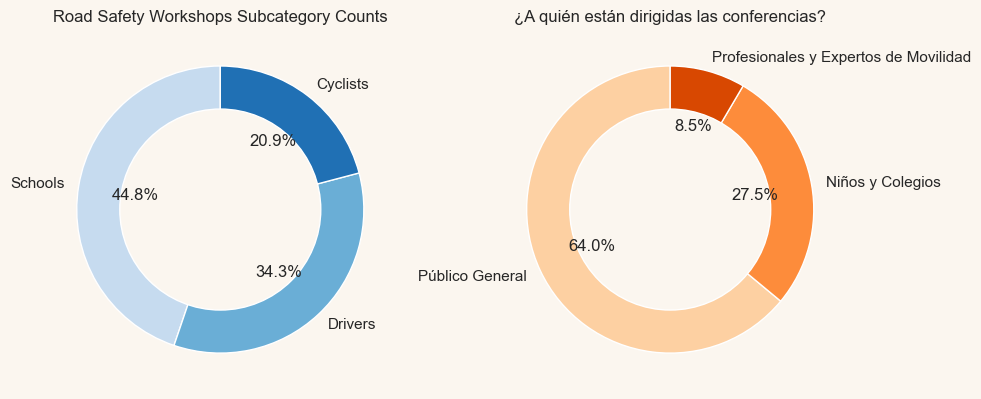

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn
sns.set(style='whitegrid')

# Step 1: Read the generated classification CSV files
road_safety_df = pd.read_csv('../data/road_safety_subclassification.csv')
conference_df = pd.read_csv('../data/conference_subclassification.csv')

# Step 2: Count the occurrences of each subcategory for Road Safety Workshops
road_safety_counts = road_safety_df['secondary_classification'].value_counts().reset_index()
road_safety_counts.columns = ['Subcategory', 'Count']

# Step 3: Count the occurrences of each subcategory for Conferences
conference_counts = conference_df['secondary_classification'].value_counts().reset_index()
conference_counts.columns = ['Subcategory', 'Count']

# Step 4: Create donut plots for Road Safety Subcategories
fig=plt.figure(figsize=(10, 6))

# Set the background color for the figure and axes
fig.patch.set_facecolor('#fbf6ef')  # Background of the figure
ax.set_facecolor('#fbf6ef')  # Background of the axes
# Donut plot for Road Safety Workshops
plt.subplot(1, 2, 1)
plt.pie(road_safety_counts['Count'], labels=road_safety_counts['Subcategory'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Blues', len(road_safety_counts)))
centre_circle = plt.Circle((0, 0), 0.70, fc='#fbf6ef')  # Create a white circle in the center
fig = plt.gcf()
fig.gca().add_artist(centre_circle)  # Add the circle to the plot

plt.title('Road Safety Workshops Subcategory Counts')

# Step 5: Create donut plots for Conference Subcategories
# Donut plot for Conferences
plt.subplot(1, 2, 2)
plt.pie(conference_counts['Count'], labels=['Público General','Niños y Colegios','Profesionales y Expertos de Movilidad'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Oranges', len(conference_counts)))
centre_circle = plt.Circle((0, 0), 0.70, fc='#fbf6ef')  # Create a white circle in the center
fig = plt.gcf()
fig.gca().add_artist(centre_circle)  # Add the circle to the plot
plt.title('¿A quién están dirigidas las conferencias?')

# Step 6: Show the plots
plt.tight_layout()
plt.show()


In [44]:
display(road_safety_df[road_safety_df['secondary_classification'] == 'Drivers'])

,ID,secondary_result,secondary_classification,secondary_score
4,151,{'sequence': 'This is an event called \'Confer...,Drivers,0.817564
6,205,"{'sequence': ""This is an event called 'Road Ed...",Drivers,0.539326
11,280,"{'sequence': ""This is an event called 'Road sa...",Drivers,0.486807
12,311,"{'sequence': ""This is an event called 'Lutagan...",Drivers,0.401656
17,401,"{'sequence': ""This is an event called 'Road Ed...",Drivers,0.606310
19,443,"{'sequence': ""This is an event called 'Road sa...",Drivers,0.501950
22,509,"{'sequence': ""This is an event called 'Demonst...",Drivers,0.401852
24,553,"{'sequence': ""This is an event called 'XXX VOP...",Drivers,0.792925
26,590,"{'sequence': ""This is an event called 'Vial ed...",Drivers,0.510329
31,643,"{'sequence': ""This is an event called 'Learnin...",Drivers,0.589379
